In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drivePath = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Tue Jun 29 13:42:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
SEED = 1234

import torch
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Download dataset from official website

In [ ]:
#@title Download CoNSeP
!rm -rf CoNSeP
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
!unzip /content/consep.zip > /dev/null
!rm -rf _*; rm /content/consep.zip

--2021-06-29 13:43:14--  https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  1.45MB/s    in 55s     

2021-06-29 13:44:08 (2.67 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [ ]:
import os
import scipy.io
import numpy as np
from PIL import Image

In [ ]:
#@title view labels and images
# mat = scipy.io.loadmat('/content/CoNSeP/Train/Labels/train_1.mat')

import matplotlib.pyplot as plt

# H = mat['inst_map']

# plt.imshow(H, interpolation='none')
# plt.show()

# H = mat['type_map']

# plt.imshow(H, interpolation='none')
# plt.show()

# image = np.array(Image.open('/content/CoNSeP/Train/Images/train_24.png'))
# H = image[:,:,3]

# plt.imshow(H, interpolation='none')
# plt.show()

# Data loaders

In [ ]:
import torch.nn as nn

class ConsepSimplePadDataset(torch.utils.data.Dataset):
  def __init__(self, train = False, test = False):
        self.directory = 'CoNSeP/Train' if train else 'CoNSeP/Test'
        self.setname = 'train' if train else 'test'
        assert train != test

  def __len__(self):
        return len(os.listdir(os.path.join(self.directory, 'Images')))

  def __getitem__(self, index):
        # Load data and get label
        image = np.array(Image.open(os.path.join(self.directory, 'Images', self.setname + f'_{index + 1}.png')))[:,:,:3]
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))) / 255

        labels = scipy.io.loadmat(os.path.join(self.directory, 'Labels', self.setname + f'_{index + 1}.mat'))
        label_inst = torch.from_numpy(labels['inst_map']).long()
        label_type = torch.from_numpy(labels['type_map']).long()

        m = nn.ZeroPad2d(12)

        return m(image), m(label_inst), m(label_type)

In [ ]:
# CUDA for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 0}

# Generators
training_set = ConsepSimplePadDataset(train = True)
validation_len = int(len(training_set) * 0.3)

training_set, validation_set = torch.utils.data.random_split(training_set, [len(training_set) - validation_len, validation_len])
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = ConsepSimplePadDataset(test = True)
test_generator = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
n_type = 8
ratio_type = torch.ones(n_type)
ratio_inst = torch.ones(2)
for _, local_labels_inst, local_labels_type in training_generator:
    for i in range(n_type):
        ratio_type[i] += torch.sum(local_labels_type == i)
    ratio_inst[0] += torch.sum(local_labels_inst == 0)
    ratio_inst[1] += torch.sum(local_labels_inst > 0)

# Model

In [ ]:
#@title clone UNetPlusPlus
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html >/dev/null
!pip install torchtext==0.9.1 >/dev/null
!pip install segmentation-models-pytorch >/dev/null
import segmentation_models_pytorch

In [ ]:
model = segmentation_models_pytorch.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=n_type, activation=None, aux_params=None)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 26,079,624 trainable parameters


# Training

In [ ]:
from torch import optim

optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-8, momentum=0.9)

if n_type > 1:
    criterion = nn.CrossEntropyLoss(weight = 1 / torch.log(ratio_type).to(device))
else:
    criterion = nn.CrossEntropyLoss(weight = 1 / torch.log(ratio_inst).to(device))

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).float().mean()
    acc = correct
    return acc

In [ ]:
def binary_metric(preds, y, n_classes=8):
    rounded_preds = preds.argmax(1)
    scores = []
    t = rounded_preds == y
    for i in range(n_classes):
        p = rounded_preds == i
        tp = torch.sum(torch.logical_and(t, p).float(), dim = 1)
        fp = torch.sum(torch.logical_and(torch.logical_not(t), p).float(), dim = 1)
        fn = torch.sum(torch.logical_and(torch.logical_and(torch.logical_not(t), torch.logical_not(p)), y == i).float(), dim = 1)

        recall = tp / (tp + fn + 1e-10)
        prec = tp / (tp + fp + 1e-10)
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-10)
        f2 = 5 * tp / (5 * tp + 4 * fn + fp + 1e-10)
        scores.append([recall.mean(), prec.mean(), f1.mean(), f2.mean()])
    
    return torch.tensor(scores)

In [ ]:
from tqdm.notebook import tqdm

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    statistics = []

    model.train()

    for local_batch, local_labels_inst, local_labels_type in tqdm(iterator):

        # Transfer to GPU
        local_batch, local_labels_inst, local_labels_type = local_batch.to(device), local_labels_inst.to(device), local_labels_type.to(device)
        
        optimizer.zero_grad()
     
        type_pred = model(local_batch)
        
        loss = criterion(type_pred, local_labels_type)
        
        acc = categorical_accuracy(type_pred, local_labels_type)

        statistics.append(binary_metric(type_pred, local_labels_type))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), sum(statistics) / len(statistics)

In [ ]:
def evaluate(model, iterator, criterion, demo = False):
    
    epoch_loss = 0
    epoch_acc = 0
    statistics = []

    model.eval()

    with torch.no_grad():

        for local_batch, local_labels_inst, local_labels_type in tqdm(iterator):

            # Transfer to GPU
            local_batch, local_labels_inst, local_labels_type = local_batch.to(device), local_labels_inst.to(device), local_labels_type.to(device)

            type_pred = model(local_batch)
        
            loss = criterion(type_pred, local_labels_type)
            
            acc = categorical_accuracy(type_pred, local_labels_type)

            statistics.append(binary_metric(type_pred, local_labels_type))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #demo
            if demo:
                truth = local_labels_type.squeeze(0).cpu().numpy()
                plt.imshow(np.concatenate((type_pred.argmax(1).squeeze(0).cpu().numpy(), truth), axis = 1), interpolation='none')
                plt.show()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), sum(statistics) / len(statistics)

In [ ]:
def quality_metric(preds, y, n_classes=8):
  
    rounded_preds = preds.argmax(1)
    scores = []
    t = rounded_preds == y
    for i in range(n_classes):
        p = rounded_preds == i
        l = y == i
        tp = torch.sum(torch.logical_and(t, p).float(), dim = 1)
        fp = torch.sum(torch.logical_and(torch.logical_not(t), p).float(), dim = 1)
        fn = torch.sum(torch.logical_and(torch.logical_and(torch.logical_not(t), torch.logical_not(p)), y == i).float(), dim = 1)
        
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-10)

        intersection = (l & p).float().sum((1, 2)) 
        union = (l | p).float().sum((1, 2)) 
        
        iou = (intersection + 1e-10) / (union + 1e-10)

        scores.append([f1.mean(), iou, f1.mean()*iou])
    
    return torch.tensor(scores)

def classification_eval(preds, y):

    rounded_preds = preds.argmax(1)
    TPd = rounded_preds & y
    t = rounded_preds == y
    Ac = torch.logical_and(TPd, t).float().sum((1, 2))
    Bc = torch.logical_and(TPd, torch.logical_not(t)).float().sum((1, 2))
    incorrectDetection = torch.logical_xor(rounded_preds, y).float().sum((1, 2))
    
    Fc = (2*Ac+1e-10)/(2*(Ac+Bc)+incorrectDetection+1e-10)

    return Fc


In [ ]:
def new_evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    segmentation_scores = []
    classification_scores = []
    model.eval()

    with torch.no_grad():

        for local_batch, local_labels_inst, local_labels_type in tqdm(iterator):

            # Transfer to GPU
            local_batch, local_labels_inst, local_labels_type = local_batch.to(device), local_labels_inst.to(device), local_labels_type.to(device)

            type_pred = model(local_batch)

            loss = criterion(type_pred, local_labels_type)
            
            acc = categorical_accuracy(type_pred, local_labels_type)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            segmentation_scores.append(quality_metric(type_pred, local_labels_type))
            classification_scores.append(classification_eval(type_pred, local_labels_type))

    return epoch_loss / len(iterator), epoch_acc / len(iterator), sum(segmentation_scores) / len(segmentation_scores), sum(classification_scores) / len(classification_scores)






In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_stats = train(model, training_generator, optimizer, criterion)
    valid_loss, valid_acc, valid_segmentation_stats, valid_classification_score = new_evaluate(model, validation_generator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), drivePath + 'unetplusplus.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('train metrics R, P, F1, F2')
    print((train_stats * 1e4).long())
    print('valid metrics DQ, SQ, PQ')
    print((valid_segmentation_stats * 1e4).long())
    print('valid classification score: ', valid_classification_score)


Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 0.439 | Train Acc: 86.51%
	 Val. Loss: 0.463 |  Val. Acc: 83.70%
train metrics R, P, F1, F2
tensor([[9457, 9332, 9373, 9418],
        [   0,    0,    0,    0],
        [   9,   67,   14,   11],
        [   0,    0,    0,    0],
        [3123, 3073, 2902, 2981],
        [1092, 1812, 1098, 1046],
        [1117,  995,  983, 1033],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9479, 9079, 8646],
        [   0, 6250,    0],
        [   0,    0,    0],
        [   0, 8750,    0],
        [   0, 1250,    0],
        [ 498,  466,   41],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0317], device='cuda:0')



Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.415 | Train Acc: 87.08%
	 Val. Loss: 0.483 |  Val. Acc: 87.05%
train metrics R, P, F1, F2
tensor([[9491, 9298, 9375, 9440],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3003, 3227, 3012, 2989],
        [1877, 2431, 1743, 1726],
        [1054, 1028,  950,  973],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9553, 9192, 8808],
        [   0, 6250,    0],
        [   0,    0,    0],
        [   0, 8750,    0],
        [   0, 8750,    0],
        [1315,  984,  201],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1460], device='cuda:0')



Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.414 | Train Acc: 87.08%
	 Val. Loss: 0.540 |  Val. Acc: 81.88%
train metrics R, P, F1, F2
tensor([[9538, 9279, 9395, 9478],
        [   0,    0,    0,    0],
        [ 101,  400,  144,  113],
        [   0,    0,    0,    0],
        [3159, 3047, 2999, 3069],
        [1402, 1846, 1341, 1325],
        [ 318,  675,  405,  344],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9395, 8955, 8469],
        [   0, 6250,    0],
        [   3,    4,    0],
        [   0, 8750,    0],
        [   0, 1250,    0],
        [ 755,  788,  197],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0348], device='cuda:0')



Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.407 | Train Acc: 87.64%
	 Val. Loss: 0.719 |  Val. Acc: 86.95%
train metrics R, P, F1, F2
tensor([[9492, 9379, 9425, 9462],
        [   0,    0,    0,    0],
        [  76,  412,  117,   88],
        [   0,    0,    0,    0],
        [3133, 3173, 3090, 3099],
        [2050, 2247, 1743, 1820],
        [1271,  903,  994, 1108],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9494, 9088, 8660],
        [   0, 6250,    0],
        [   4,    6,    0],
        [   0, 8750,    0],
        [   0, 2500,    0],
        [  81,  145,    4],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0071], device='cuda:0')



Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.421 | Train Acc: 86.88%
	 Val. Loss: 0.447 |  Val. Acc: 83.23%
train metrics R, P, F1, F2
tensor([[9484, 9311, 9375, 9435],
        [   0,    0,    0,    0],
        [  18,   87,   27,   20],
        [   0,    0,    0,    0],
        [3127, 3089, 2977, 3031],
        [1644, 1982, 1456, 1496],
        [ 746,  919,  725,  719],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9352, 8892, 8384],
        [   0, 6250,    0],
        [ 772,  501,  103],
        [   0, 8750,    0],
        [   0,    0,    0],
        [1735, 1396,  463],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1631], device='cuda:0')



Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 0.400 | Train Acc: 87.49%
	 Val. Loss: 0.365 |  Val. Acc: 87.48%
train metrics R, P, F1, F2
tensor([[9514, 9336, 9414, 9471],
        [   0,    0,    0,    0],
        [ 593, 1308,  719,  629],
        [   0,    0,    0,    0],
        [3224, 3209, 3145, 3172],
        [1871, 2570, 1890, 1818],
        [ 412,  638,  352,  365],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9574, 9226, 8857],
        [   0, 6250,    0],
        [  21,   17,    0],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [1461, 1125,  256],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1551], device='cuda:0')



Epoch: 07 | Epoch Time: 0m 44s
	Train Loss: 0.390 | Train Acc: 87.83%
	 Val. Loss: 0.562 |  Val. Acc: 84.53%
train metrics R, P, F1, F2
tensor([[9496, 9343, 9402, 9454],
        [   0,    0,    0,    0],
        [ 216,  730,  303,  241],
        [   0,    0,    0,    0],
        [3032, 3246, 3001, 3003],
        [2320, 2610, 2115, 2147],
        [1062, 1222, 1012, 1017],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9507, 9121, 8706],
        [   0, 6250,    0],
        [  48,   75,    2],
        [   0, 8750,    0],
        [   0,    0,    0],
        [ 534,  636,   81],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0342], device='cuda:0')



Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 0.394 | Train Acc: 87.78%
	 Val. Loss: 0.374 |  Val. Acc: 87.50%
train metrics R, P, F1, F2
tensor([[9504, 9346, 9412, 9464],
        [   0,    0,    0,    0],
        [ 249,  764,  330,  273],
        [   0,    0,    0,    0],
        [3300, 3030, 3066, 3176],
        [1659, 2514, 1696, 1617],
        [1056, 1053,  979,  999],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9557, 9198, 8816],
        [   0, 6250,    0],
        [ 205,  118,    9],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [1362, 1071,  219],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1531], device='cuda:0')



Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 0.388 | Train Acc: 87.96%
	 Val. Loss: 0.449 |  Val. Acc: 87.23%
train metrics R, P, F1, F2
tensor([[9537, 9308, 9407, 9481],
        [   0,    0,    0,    0],
        [  17,  191,   30,   21],
        [   0,    0,    0,    0],
        [3139, 3300, 3139, 3122],
        [1782, 2485, 1752, 1707],
        [1263,  927,  997, 1107],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9567, 9216, 8841],
        [   0, 6250,    0],
        [  30,   16,    0],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [1391, 1100,  232],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1484], device='cuda:0')



Epoch: 10 | Epoch Time: 0m 44s
	Train Loss: 0.393 | Train Acc: 87.77%
	 Val. Loss: 0.375 |  Val. Acc: 87.34%
train metrics R, P, F1, F2
tensor([[9466, 9403, 9423, 9446],
        [   0,    0,    0,    0],
        [ 254, 1039,  367,  287],
        [   0,    0,    0,    0],
        [3253, 3187, 3127, 3176],
        [2497, 2718, 2284, 2318],
        [1084, 1014,  998, 1031],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9547, 9181, 8792],
        [   0, 6250,    0],
        [  29,   17,    0],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [1216,  960,  191],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1270], device='cuda:0')



Epoch: 11 | Epoch Time: 0m 44s
	Train Loss: 0.385 | Train Acc: 88.01%
	 Val. Loss: 0.387 |  Val. Acc: 86.85%
train metrics R, P, F1, F2
tensor([[9515, 9360, 9425, 9476],
        [   0,    0,    0,    0],
        [  66,  275,   96,   75],
        [   0,    0,    0,    0],
        [3143, 3292, 3144, 3128],
        [2674, 2496, 2262, 2388],
        [1042, 1021,  931,  962],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9552, 9192, 8807],
        [   0, 6250,    0],
        [  92,   56,    3],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [1413, 1080,  246],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1581], device='cuda:0')



Epoch: 12 | Epoch Time: 0m 44s
	Train Loss: 0.378 | Train Acc: 88.18%
	 Val. Loss: 0.463 |  Val. Acc: 87.01%
train metrics R, P, F1, F2
tensor([[9517, 9341, 9416, 9473],
        [   0,    0,    0,    0],
        [ 263,  744,  339,  286],
        [   0,    0,    0,    0],
        [3075, 3237, 3065, 3054],
        [2233, 2807, 2123, 2112],
        [1029, 1324, 1084, 1037],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9564, 9211, 8836],
        [   0, 6250,    0],
        [   0,    0,    0],
        [   0, 8750,    0],
        [   0, 8750,    0],
        [1426, 1021,  227],
        [   0, 1250,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1605], device='cuda:0')



Epoch: 13 | Epoch Time: 0m 44s
	Train Loss: 0.395 | Train Acc: 87.66%
	 Val. Loss: 0.698 |  Val. Acc: 69.68%
train metrics R, P, F1, F2
tensor([[9491, 9353, 9411, 9456],
        [   0,    0,    0,    0],
        [ 450, 1022,  555,  481],
        [   0,    0,    0,    0],
        [3244, 3235, 3158, 3188],
        [1947, 2551, 1821, 1828],
        [ 677, 1029,  727,  683],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[8457, 7602, 6666],
        [   0, 6250,    0],
        [ 285,  795,   37],
        [   0, 8750,    0],
        [   0,    0,    0],
        [ 251,  231,   45],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0167], device='cuda:0')



Epoch: 14 | Epoch Time: 0m 44s
	Train Loss: 0.376 | Train Acc: 88.31%
	 Val. Loss: 0.371 |  Val. Acc: 86.43%
train metrics R, P, F1, F2
tensor([[9517, 9399, 9448, 9486],
        [   0,    0,    0,    0],
        [ 625, 1418,  764,  663],
        [   0,    0,    0,    0],
        [3224, 3271, 3173, 3186],
        [2384, 2721, 2171, 2204],
        [1104, 1002, 1016, 1055],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9569, 9224, 8853],
        [   0, 6250,    0],
        [ 287,  173,   20],
        [   0, 8750,    0],
        [   0, 3750,    0],
        [1829, 1303,  385],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.2022], device='cuda:0')



Epoch: 15 | Epoch Time: 0m 44s
	Train Loss: 0.378 | Train Acc: 88.19%
	 Val. Loss: 0.371 |  Val. Acc: 87.25%
train metrics R, P, F1, F2
tensor([[9561, 9303, 9416, 9499],
        [   0,    0,    0,    0],
        [ 603, 1392,  726,  633],
        [   0,    0,    0,    0],
        [3256, 3135, 3114, 3176],
        [1270, 2454, 1419, 1294],
        [1189, 1070, 1006, 1075],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9566, 9213, 8838],
        [   0, 6250,    0],
        [ 341,  219,   45],
        [   0, 8750,    0],
        [   0, 3750,    0],
        [1421, 1088,  243],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1715], device='cuda:0')



Epoch: 16 | Epoch Time: 0m 44s
	Train Loss: 0.399 | Train Acc: 87.61%
	 Val. Loss: 0.476 |  Val. Acc: 85.73%
train metrics R, P, F1, F2
tensor([[9551, 9300, 9411, 9492],
        [   0,    0,    0,    0],
        [ 312,  969,  411,  342],
        [   0,    0,    0,    0],
        [3149, 3182, 3057, 3087],
        [1727, 2363, 1525, 1534],
        [ 850, 1046,  812,  797],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9586, 9248, 8888],
        [   0, 6250,    0],
        [ 137,  220,   16],
        [   0, 8750,    0],
        [   0, 1250,    0],
        [ 666,  753,  129],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0440], device='cuda:0')



Epoch: 17 | Epoch Time: 0m 44s
	Train Loss: 0.385 | Train Acc: 88.32%
	 Val. Loss: 0.368 |  Val. Acc: 87.32%
train metrics R, P, F1, F2
tensor([[9497, 9374, 9423, 9464],
        [   0,    0,    0,    0],
        [ 940, 1597, 1045,  957],
        [   0,    0,    0,    0],
        [3386, 3208, 3235, 3308],
        [1737, 2836, 1833, 1714],
        [1367,  844,  949, 1126],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9559, 9206, 8825],
        [   0, 6250,    0],
        [1024,  760,  235],
        [   0, 8750,    0],
        [   0, 3750,    0],
        [1452, 1185,  260],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.2036], device='cuda:0')



Epoch: 18 | Epoch Time: 0m 44s
	Train Loss: 0.367 | Train Acc: 88.62%
	 Val. Loss: 0.389 |  Val. Acc: 88.23%
train metrics R, P, F1, F2
tensor([[9576, 9355, 9457, 9526],
        [   0,    0,    0,    0],
        [1161, 1747, 1264, 1175],
        [   0,    0,    0,    0],
        [3193, 3296, 3163, 3162],
        [2173, 2798, 2122, 2078],
        [ 931, 1028,  913,  908],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9572, 9222, 8851],
        [   0, 6250,    0],
        [ 907,  674,  196],
        [   0, 8750,    0],
        [   0, 3750,    0],
        [1115,  931,  148],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1717], device='cuda:0')



Epoch: 19 | Epoch Time: 0m 44s
	Train Loss: 0.367 | Train Acc: 88.39%
	 Val. Loss: 0.422 |  Val. Acc: 87.53%
train metrics R, P, F1, F2
tensor([[9548, 9360, 9437, 9500],
        [   7,   21,   11,    8],
        [ 518, 1371,  687,  570],
        [   0,    0,    0,    0],
        [3053, 3347, 3067, 3035],
        [2489, 2860, 2365, 2364],
        [1167,  997, 1007, 1069],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9561, 9206, 8827],
        [   0, 6250,    0],
        [ 797,  585,  156],
        [   0, 8750,    0],
        [   0, 3750,    0],
        [1137,  950,  161],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1594], device='cuda:0')



Epoch: 20 | Epoch Time: 0m 44s
	Train Loss: 0.386 | Train Acc: 88.61%
	 Val. Loss: 0.577 |  Val. Acc: 77.28%
train metrics R, P, F1, F2
tensor([[9530, 9383, 9445, 9493],
        [ 118,  130,  116,  116],
        [ 529, 1252,  654,  563],
        [   0,    0,    0,    0],
        [3395, 3180, 3188, 3284],
        [1990, 2440, 1871, 1855],
        [ 781, 1075,  819,  785],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9001, 8334, 7608],
        [   0, 6250,    0],
        [1221, 1005,  329],
        [   0, 8750,    0],
        [   0,    0,    0],
        [ 477,  229,   44],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1001], device='cuda:0')



Epoch: 21 | Epoch Time: 0m 44s
	Train Loss: 0.376 | Train Acc: 88.22%
	 Val. Loss: 0.415 |  Val. Acc: 87.92%
train metrics R, P, F1, F2
tensor([[9535, 9392, 9449, 9497],
        [  57,  102,   70,   61],
        [ 507, 1285,  668,  556],
        [   0,    0,    0,    0],
        [3110, 3385, 3122, 3089],
        [2606, 2736, 2336, 2409],
        [1182, 1008, 1039, 1098],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9569, 9218, 8845],
        [   0, 6250,    0],
        [1119, 1428,  242],
        [   0, 8750,    0],
        [   0, 2500,    0],
        [ 769,  711,   83],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1499], device='cuda:0')



Epoch: 22 | Epoch Time: 0m 44s
	Train Loss: 0.372 | Train Acc: 88.56%
	 Val. Loss: 0.394 |  Val. Acc: 86.25%
train metrics R, P, F1, F2
tensor([[9477, 9444, 9450, 9464],
        [   6,   15,    8,    7],
        [ 989, 1797, 1156, 1033],
        [   0,    0,    0,    0],
        [3352, 3339, 3282, 3307],
        [2605, 3009, 2462, 2473],
        [1159, 1418, 1201, 1159],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9516, 9136, 8729],
        [   0, 6250,    0],
        [ 659,  510,  104],
        [   0, 8750,    0],
        [   0, 7500,    0],
        [1878, 1288,  401],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.2315], device='cuda:0')



Epoch: 23 | Epoch Time: 0m 44s
	Train Loss: 0.356 | Train Acc: 89.03%
	 Val. Loss: 0.370 |  Val. Acc: 89.29%
train metrics R, P, F1, F2
tensor([[9527, 9375, 9436, 9487],
        [  55,   87,   64,   58],
        [ 957, 1658, 1099,  991],
        [   0,    0,    0,    0],
        [3345, 3320, 3259, 3293],
        [2408, 2818, 2281, 2280],
        [1143,  951,  947, 1023],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9578, 9233, 8865],
        [   0, 6250,    0],
        [1700, 2001,  663],
        [   0, 8750,    0],
        [   0, 2500,    0],
        [1265, 1054,  190],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.2263], device='cuda:0')



Epoch: 24 | Epoch Time: 0m 44s
	Train Loss: 0.372 | Train Acc: 88.53%
	 Val. Loss: 0.547 |  Val. Acc: 87.88%
train metrics R, P, F1, F2
tensor([[9609, 9348, 9467, 9549],
        [ 124,  131,  121,  121],
        [ 661, 1353,  775,  688],
        [   0,    0,    0,    0],
        [3278, 3338, 3234, 3244],
        [1597, 2551, 1646, 1547],
        [ 488,  672,  529,  498],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9544, 9172, 8780],
        [   0, 6250,    0],
        [ 111,   62,    3],
        [   0, 8750,    0],
        [   0, 6250,    0],
        [ 941,  771,  129],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1104], device='cuda:0')



Epoch: 25 | Epoch Time: 0m 44s
	Train Loss: 0.376 | Train Acc: 88.23%
	 Val. Loss: 0.472 |  Val. Acc: 87.08%
train metrics R, P, F1, F2
tensor([[9594, 9309, 9436, 9527],
        [  31,   79,   44,   35],
        [ 638, 1277,  728,  657],
        [   0,    0,    0,    0],
        [3032, 3436, 3115, 3043],
        [2567, 2848, 2383, 2411],
        [ 783,  572,  627,  701],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9584, 9244, 8881],
        [   0, 6250,    0],
        [ 717,  747,  133],
        [   0, 8750,    0],
        [   0,    0,    0],
        [ 216,  119,    8],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0960], device='cuda:0')



Epoch: 26 | Epoch Time: 0m 44s
	Train Loss: 0.352 | Train Acc: 88.74%
	 Val. Loss: 0.459 |  Val. Acc: 88.43%
train metrics R, P, F1, F2
tensor([[9509, 9446, 9465, 9488],
        [  51,   41,   43,   46],
        [1005, 1813, 1162, 1042],
        [   0,    0,    0,    0],
        [3319, 3361, 3255, 3273],
        [2137, 2720, 2142, 2081],
        [1321, 1275, 1238, 1270],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9544, 9174, 8782],
        [   0, 6250,    0],
        [1071, 1006,  279],
        [   0, 8750,    0],
        [   0, 1250,    0],
        [ 778,  665,   80],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.1462], device='cuda:0')



Epoch: 27 | Epoch Time: 0m 44s
	Train Loss: 0.339 | Train Acc: 89.46%
	 Val. Loss: 0.505 |  Val. Acc: 86.19%
train metrics R, P, F1, F2
tensor([[9606, 9407, 9498, 9561],
        [ 151,  131,  133,  141],
        [ 814, 1650,  963,  854],
        [   0,    0,    0,    0],
        [3355, 3355, 3294, 3316],
        [2237, 3069, 2322, 2217],
        [1143, 1451, 1143, 1126],
        [   0,    0,    0,    0]])
valid metrics DQ, SQ, PQ
tensor([[9577, 9233, 8866],
        [   0, 6250,    0],
        [ 347,  314,   26],
        [   0, 8750,    0],
        [   0, 1250,    0],
        [ 525,  479,   77],
        [   0, 5000,    0],
        [   0, 6250,    0]])
valid classification score:  tensor([0.0659], device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_stats = train(model, training_generator, optimizer, criterion)
    valid_loss, valid_acc, valid_stats = evaluate(model, validation_generator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), drivePath + 'unetplusplus.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('train metrics R, P, F1, F2')
    print((train_stats * 1e4).long())
    print('valid metrics R, P, F1, F2')
    print((valid_stats * 1e4).long())


Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.651 | Train Acc: 82.59%
	 Val. Loss: 0.601 |  Val. Acc: 88.60%
train metrics R, P, F1, F2
tensor([[10000,  8259,  8994,  9554],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0]])
valid metrics R, P, F1, F2
tensor([[10000,  8860,  9335,  9702],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0]])



Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.621 | Train Acc: 82.59%
	 Val. Loss: 0.979 |  Val. Acc: 88.60%
train metrics R, P, F1, F2
tensor([[10000,  8259,  8994,  9554],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0]])
valid metrics R, P, F1, F2
tensor([[10000,  8860,  9335,  9702],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0]])



Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.567 | Train Acc: 82.59%
	 Val. Loss: 1.096 |  Val. Acc: 88.39%
train metrics R, P, F1, F2
tensor([[10000,  8259,  8994,  9554],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     0]])
valid metrics R, P, F1, F2
tensor([[9972, 8856, 9322, 9681],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.543 | Train Acc: 84.37%
	 Val. Loss: 0.547 |  Val. Acc: 87.40%
train metrics R, P, F1, F2
tensor([[9698, 8887, 9240, 9499],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1993, 2736, 2183, 2040],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9829, 9101, 9426, 9656],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.521 | Train Acc: 85.18%
	 Val. Loss: 0.494 |  Val. Acc: 87.12%
train metrics R, P, F1, F2
tensor([[9669, 8970, 9283, 9504],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2385, 2999, 2547, 2425],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9789, 9163, 9447, 9643],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.516 | Train Acc: 85.06%
	 Val. Loss: 0.501 |  Val. Acc: 82.45%
train metrics R, P, F1, F2
tensor([[9586, 9117, 9324, 9473],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2618, 2919, 2645, 2599],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9162, 9043, 9088, 9128],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.500 | Train Acc: 85.76%
	 Val. Loss: 0.499 |  Val. Acc: 86.71%
train metrics R, P, F1, F2
tensor([[9622, 9097, 9336, 9501],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2755, 2940, 2733, 2714],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9736, 9408, 9560, 9662],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.511 | Train Acc: 84.70%
	 Val. Loss: 0.694 |  Val. Acc: 87.58%
train metrics R, P, F1, F2
tensor([[9529, 9088, 9273, 9417],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2654, 2879, 2524, 2540],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9852, 9147, 9465, 9687],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 0.517 | Train Acc: 84.48%
	 Val. Loss: 0.536 |  Val. Acc: 87.94%
train metrics R, P, F1, F2
tensor([[9424, 9231, 9290, 9361],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2897, 2768, 2647, 2727],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9907, 9208, 9523, 9744],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 0.502 | Train Acc: 85.49%
	 Val. Loss: 0.557 |  Val. Acc: 86.52%
train metrics R, P, F1, F2
tensor([[9684, 8979, 9290, 9514],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2483, 2836, 2424, 2402],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9712, 9438, 9560, 9647],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 11 | Epoch Time: 0m 20s
	Train Loss: 0.488 | Train Acc: 85.61%
	 Val. Loss: 0.499 |  Val. Acc: 87.57%
train metrics R, P, F1, F2
tensor([[9565, 9119, 9312, 9455],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2875, 2879, 2723, 2772],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9854, 9142, 9460, 9685],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 12 | Epoch Time: 0m 20s
	Train Loss: 0.462 | Train Acc: 86.07%
	 Val. Loss: 0.703 |  Val. Acc: 85.96%
train metrics R, P, F1, F2
tensor([[9599, 9097, 9323, 9482],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2947, 2934, 2814, 2857],
        [   0,    0,    0,    0],
        [ 166,  244,  176,  167],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9650, 9442, 9528, 9596],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  34,  168,   48,   38],
        [   0,    0,    0,    0]])



Epoch: 13 | Epoch Time: 0m 20s
	Train Loss: 0.467 | Train Acc: 85.71%
	 Val. Loss: 0.567 |  Val. Acc: 87.57%
train metrics R, P, F1, F2
tensor([[9546, 9105, 9297, 9438],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2800, 2947, 2650, 2690],
        [   0,    0,    0,    0],
        [ 960,  962,  798,  844],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9847, 9313, 9559, 9726],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 114,  338,  149,  123],
        [   0,    0,    0,    0]])



Epoch: 14 | Epoch Time: 0m 20s
	Train Loss: 0.487 | Train Acc: 85.27%
	 Val. Loss: 0.558 |  Val. Acc: 83.65%
train metrics R, P, F1, F2
tensor([[9503, 9182, 9305, 9413],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2602, 2828, 2491, 2525],
        [   0,    0,    0,    0],
        [ 833, 1030,  845,  818],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9343, 9697, 9488, 9394],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  10,   31,   13,   11],
        [   0,    0,    0,    0]])



Epoch: 15 | Epoch Time: 0m 20s
	Train Loss: 0.458 | Train Acc: 86.54%
	 Val. Loss: 0.536 |  Val. Acc: 81.59%
train metrics R, P, F1, F2
tensor([[9636, 9098, 9344, 9513],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2804, 3015, 2810, 2785],
        [   0,    0,    0,    0],
        [ 966, 1109,  880,  884],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9075, 9800, 9383, 9188],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 16 | Epoch Time: 0m 20s
	Train Loss: 0.464 | Train Acc: 86.12%
	 Val. Loss: 2.605 |  Val. Acc: 86.16%
train metrics R, P, F1, F2
tensor([[9489, 9225, 9338, 9423],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3111, 2922, 2869, 2979],
        [   0,    0,    0,    0],
        [ 194,  588,  269,  217],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9661, 9225, 9421, 9559],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 101,  360,  145,  114],
        [   0,    0,    0,    0]])



Epoch: 17 | Epoch Time: 0m 20s
	Train Loss: 0.452 | Train Acc: 85.95%
	 Val. Loss: 0.515 |  Val. Acc: 79.60%
train metrics R, P, F1, F2
tensor([[9527, 9175, 9326, 9440],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3017, 2864, 2802, 2888],
        [  84,  332,  119,   94],
        [ 591, 1041,  631,  590],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8786, 9374, 9041, 8881],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 509, 1604,  654,  549],
        [  65,  268,   89,   71],
        [   0,    0,    0,    0]])



Epoch: 18 | Epoch Time: 0m 20s
	Train Loss: 0.450 | Train Acc: 85.90%
	 Val. Loss: 0.539 |  Val. Acc: 85.36%
train metrics R, P, F1, F2
tensor([[9514, 9225, 9350, 9444],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2689, 2753, 2588, 2620],
        [ 121,  523,  146,  124],
        [1256,  981,  993, 1109],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9568, 9600, 9571, 9566],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  29,  138,   45,   33],
        [   0,    0,    0,    0]])



Epoch: 19 | Epoch Time: 0m 20s
	Train Loss: 0.437 | Train Acc: 86.85%
	 Val. Loss: 0.738 |  Val. Acc: 86.25%
train metrics R, P, F1, F2
tensor([[9538, 9179, 9338, 9453],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3276, 2960, 3006, 3133],
        [  14,  269,   25,   17],
        [ 747, 1186,  741,  711],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9696, 9257, 9449, 9589],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   2,   59,    4,    3],
        [  29,  174,   45,   33],
        [   0,    0,    0,    0]])



Epoch: 20 | Epoch Time: 0m 20s
	Train Loss: 0.434 | Train Acc: 86.26%
	 Val. Loss: 0.504 |  Val. Acc: 84.20%
train metrics R, P, F1, F2
tensor([[9513, 9209, 9338, 9437],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3148, 3011, 2953, 3030],
        [ 140,  549,  180,  150],
        [ 741, 1264,  842,  763],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9389, 9523, 9428, 9399],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 232, 1087,  331,  259],
        [ 337,  699,  412,  357],
        [   0,    0,    0,    0]])



Epoch: 21 | Epoch Time: 0m 20s
	Train Loss: 0.431 | Train Acc: 86.22%
	 Val. Loss: 0.459 |  Val. Acc: 86.96%
train metrics R, P, F1, F2
tensor([[9576, 9189, 9363, 9485],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2933, 3164, 2912, 2901],
        [ 612,  804,  494,  522],
        [ 374,  215,  254,  304],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9610, 9512, 9544, 9580],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2500, 1378, 1328, 1629],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 22 | Epoch Time: 0m 20s
	Train Loss: 0.436 | Train Acc: 86.85%
	 Val. Loss: 0.729 |  Val. Acc: 71.33%
train metrics R, P, F1, F2
tensor([[9523, 9201, 9339, 9443],
        [   0,    0,    0,    0],
        [  10,  120,   18,   12],
        [   0,    0,    0,    0],
        [3225, 2969, 2988, 3097],
        [ 860, 1647,  831,  783],
        [ 475, 1213,  632,  524],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[7792, 9899, 8512, 8038],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  11,  217,   20,   13],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 23 | Epoch Time: 0m 20s
	Train Loss: 0.443 | Train Acc: 85.76%
	 Val. Loss: 1.497 |  Val. Acc: 87.73%
train metrics R, P, F1, F2
tensor([[9546, 9078, 9270, 9423],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2804, 3022, 2640, 2683],
        [ 316, 1064,  406,  340],
        [1040,  991,  832,  898],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9867, 9117, 9448, 9686],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 457,  766,  433,  417],
        [   0,   10,    1,    0],
        [   0,    0,    0,    0]])



Epoch: 24 | Epoch Time: 0m 20s
	Train Loss: 0.445 | Train Acc: 86.19%
	 Val. Loss: 0.470 |  Val. Acc: 87.25%
train metrics R, P, F1, F2
tensor([[9469, 9232, 9330, 9408],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3181, 2953, 2946, 3052],
        [ 868, 1279,  876,  845],
        [ 506,  802,  548,  510],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9738, 9358, 9527, 9648],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1361,  525,  581,  813],
        [  48,  193,   65,   52],
        [   0,    0,    0,    0]])



Epoch: 25 | Epoch Time: 0m 20s
	Train Loss: 0.471 | Train Acc: 85.27%
	 Val. Loss: 0.565 |  Val. Acc: 88.05%
train metrics R, P, F1, F2
tensor([[9527, 9180, 9328, 9441],
        [   0,    0,    0,    0],
        [  46,  241,   68,   52],
        [   0,    0,    0,    0],
        [2659, 2997, 2583, 2597],
        [ 672, 1853,  720,  650],
        [ 992,  693,  710,  805],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9930, 8909, 9338, 9667],
        [   0,    0,    0,    0],
        [   1,   42,    2,    1],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 128,  536,  187,  145],
        [   0,    2,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 26 | Epoch Time: 0m 20s
	Train Loss: 0.413 | Train Acc: 87.21%
	 Val. Loss: 0.455 |  Val. Acc: 87.22%
train metrics R, P, F1, F2
tensor([[9571, 9212, 9378, 9490],
        [   0,    0,    0,    0],
        [   0,    1,    0,    0],
        [   0,    0,    0,    0],
        [3327, 3084, 3124, 3222],
        [ 628, 1215,  662,  626],
        [  61,  255,   89,   69],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9619, 9522, 9558, 9591],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2666, 1356, 1334, 1672],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 27 | Epoch Time: 0m 20s
	Train Loss: 0.456 | Train Acc: 85.81%
	 Val. Loss: 0.598 |  Val. Acc: 81.42%
train metrics R, P, F1, F2
tensor([[9456, 9280, 9346, 9407],
        [   0,    0,    0,    0],
        [   7,   72,   13,    9],
        [   0,    0,    0,    0],
        [2727, 3010, 2694, 2687],
        [1396, 1937, 1314, 1298],
        [ 423,  660,  370,  376],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9072, 9824, 9398, 9193],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 28 | Epoch Time: 0m 20s
	Train Loss: 0.419 | Train Acc: 87.31%
	 Val. Loss: 0.491 |  Val. Acc: 85.29%
train metrics R, P, F1, F2
tensor([[9636, 9127, 9361, 9521],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3096, 3104, 3022, 3045],
        [  91,  462,  128,  101],
        [ 918, 1310,  989,  931],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9531, 9602, 9547, 9533],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 388, 1194,  492,  412],
        [   5,   32,    8,    6],
        [   0,    0,    0,    0]])



Epoch: 29 | Epoch Time: 0m 20s
	Train Loss: 0.407 | Train Acc: 87.10%
	 Val. Loss: 0.462 |  Val. Acc: 85.98%
train metrics R, P, F1, F2
tensor([[9467, 9342, 9388, 9431],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3275, 3032, 3024, 3141],
        [ 671, 2086,  864,  720],
        [1474, 1196, 1256, 1350],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9618, 9453, 9516, 9572],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 613, 1268,  703,  625],
        [  62,  278,   92,   71],
        [   0,    0,    0,    0]])



Epoch: 30 | Epoch Time: 0m 20s
	Train Loss: 0.406 | Train Acc: 87.18%
	 Val. Loss: 1.879 |  Val. Acc: 86.84%
train metrics R, P, F1, F2
tensor([[9532, 9303, 9406, 9479],
        [  62,   94,   70,   65],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3206, 3100, 3041, 3107],
        [1201, 2068, 1139, 1096],
        [ 587, 1075,  703,  622],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9701, 9332, 9496, 9614],
        [   0,    0,    0,    0],
        [  16,  693,   29,   19],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 590, 1180,  697,  615],
        [   0,    9,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 31 | Epoch Time: 0m 20s
	Train Loss: 0.397 | Train Acc: 87.61%
	 Val. Loss: 0.457 |  Val. Acc: 86.81%
train metrics R, P, F1, F2
tensor([[9562, 9267, 9398, 9492],
        [   0,    0,    0,    0],
        [   8,  130,   14,    9],
        [   0,    0,    0,    0],
        [2939, 3244, 3007, 2951],
        [2301, 2790, 2211, 2189],
        [1021, 1322,  994,  973],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9624, 9573, 9585, 9605],
        [   0,    0,    0,    0],
        [   8,  249,   16,   10],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1943, 1629, 1352, 1450],
        [   0,    9,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 32 | Epoch Time: 0m 20s
	Train Loss: 0.389 | Train Acc: 87.72%
	 Val. Loss: 1.046 |  Val. Acc: 87.76%
train metrics R, P, F1, F2
tensor([[9481, 9362, 9411, 9451],
        [   0,    1,    0,    0],
        [   8,  114,   14,    9],
        [   0,    0,    0,    0],
        [3228, 3202, 3126, 3164],
        [2080, 2620, 1938, 1938],
        [1090, 1302, 1032, 1042],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9801, 9321, 9538, 9690],
        [   0,    0,    0,    0],
        [  34, 1103,   63,   42],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1132, 1055,  811,  865],
        [   0,    7,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 33 | Epoch Time: 0m 20s
	Train Loss: 0.405 | Train Acc: 87.36%
	 Val. Loss: 0.711 |  Val. Acc: 84.64%
train metrics R, P, F1, F2
tensor([[9538, 9266, 9382, 9470],
        [   0,    0,    0,    0],
        [   3,   37,    6,    4],
        [   0,    0,    0,    0],
        [2922, 3306, 2980, 2921],
        [2167, 2491, 2010, 2021],
        [1103, 1274, 1041, 1046],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9384, 9696, 9512, 9430],
        [   0,    0,    0,    0],
        [  14,  138,   21,   16],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 951, 1068,  801,  814],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 34 | Epoch Time: 0m 20s
	Train Loss: 0.407 | Train Acc: 87.24%
	 Val. Loss: 0.458 |  Val. Acc: 82.42%
train metrics R, P, F1, F2
tensor([[9478, 9356, 9404, 9445],
        [   0,    0,    0,    0],
        [   8,   83,   14,   10],
        [   0,    0,    0,    0],
        [3132, 3182, 3053, 3076],
        [2355, 2578, 2139, 2178],
        [ 384,  835,  409,  380],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8939, 9578, 9208, 9038],
        [   0,    0,    0,    0],
        [ 123, 1595,  222,  150],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2492, 1406, 1590, 1912],
        [ 172,  477,  216,  182],
        [   0,    0,    0,    0]])



Epoch: 35 | Epoch Time: 0m 20s
	Train Loss: 0.397 | Train Acc: 88.13%
	 Val. Loss: 1.302 |  Val. Acc: 87.59%
train metrics R, P, F1, F2
tensor([[9495, 9340, 9404, 9455],
        [   0,    4,    1,    0],
        [   4,   25,    6,    5],
        [   0,    0,    0,    0],
        [3400, 3140, 3199, 3297],
        [1853, 2487, 1749, 1748],
        [1135, 1058,  974, 1033],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9786, 9273, 9500, 9663],
        [   0,    0,    0,    0],
        [   0,   13,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1057,  778,  593,  689],
        [   0,    2,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 36 | Epoch Time: 0m 20s
	Train Loss: 0.425 | Train Acc: 86.44%
	 Val. Loss: 0.431 |  Val. Acc: 82.62%
train metrics R, P, F1, F2
tensor([[9497, 9249, 9344, 9428],
        [   4,   13,    6,    5],
        [   2,   43,    4,    3],
        [   0,    0,    0,    0],
        [2749, 3233, 2731, 2698],
        [1326, 1830, 1273, 1255],
        [ 863, 1095,  908,  874],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[8973, 9859, 9355, 9115],
        [   0,    0,    0,    0],
        [ 130,  439,  141,  129],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2423, 1198, 1382, 1714],
        [ 450,  749,  477,  444],
        [   0,    0,    0,    0]])



Epoch: 37 | Epoch Time: 0m 20s
	Train Loss: 0.408 | Train Acc: 86.78%
	 Val. Loss: 0.412 |  Val. Acc: 84.79%
train metrics R, P, F1, F2
tensor([[9482, 9328, 9393, 9444],
        [   0,    0,    0,    0],
        [   2,   26,    4,    3],
        [   0,    0,    0,    0],
        [3142, 3266, 3117, 3111],
        [2029, 2411, 1809, 1835],
        [ 497,  706,  378,  415],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9134, 9851, 9446, 9250],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [4643, 1439, 1908, 2644],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 38 | Epoch Time: 0m 20s
	Train Loss: 0.395 | Train Acc: 87.36%
	 Val. Loss: 0.404 |  Val. Acc: 87.64%
train metrics R, P, F1, F2
tensor([[9495, 9367, 9422, 9464],
        [   0,    0,    0,    0],
        [   3,   29,    6,    4],
        [   0,    0,    0,    0],
        [3123, 3188, 3061, 3078],
        [1987, 2569, 1697, 1718],
        [1210, 1322, 1115, 1131],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9724, 9490, 9593, 9668],
        [   0,    0,    0,    0],
        [   0,   17,    1,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2144, 1247, 1159, 1431],
        [   6,   23,    8,    7],
        [   0,    0,    0,    0]])



Epoch: 39 | Epoch Time: 0m 20s
	Train Loss: 0.377 | Train Acc: 88.14%
	 Val. Loss: 0.490 |  Val. Acc: 82.51%
train metrics R, P, F1, F2
tensor([[9573, 9313, 9433, 9514],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3084, 3330, 3111, 3074],
        [2053, 2646, 1915, 1899],
        [1357, 1308, 1260, 1294],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9049, 9809, 9361, 9162],
        [   0,    0,    0,    0],
        [  10,  775,   20,   12],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1728, 1623, 1512, 1580],
        [   0,    3,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 40 | Epoch Time: 0m 20s
	Train Loss: 0.388 | Train Acc: 87.50%
	 Val. Loss: 0.372 |  Val. Acc: 87.51%
train metrics R, P, F1, F2
tensor([[9491, 9341, 9401, 9451],
        [  50,   93,   61,   54],
        [  69,  357,  109,   80],
        [   0,    0,    0,    0],
        [3012, 3307, 3000, 2988],
        [2111, 2732, 2036, 2015],
        [1086, 1047,  922,  982],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9654, 9587, 9609, 9633],
        [   0,    0,    0,    0],
        [  17,  212,   30,   21],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2541, 1697, 1643, 1882],
        [ 200,  365,  233,  209],
        [   0,    0,    0,    0]])



Epoch: 41 | Epoch Time: 0m 20s
	Train Loss: 0.388 | Train Acc: 87.49%
	 Val. Loss: 0.412 |  Val. Acc: 85.25%
train metrics R, P, F1, F2
tensor([[9396, 9397, 9382, 9387],
        [   0,    0,    0,    0],
        [   0,    2,    0,    0],
        [   0,    0,    0,    0],
        [3411, 2976, 3062, 3231],
        [2127, 2262, 1828, 1898],
        [1195,  964, 1015, 1093],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9207, 9843, 9488, 9312],
        [   0,    0,    0,    0],
        [  70,  966,  123,   84],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [4389, 1460, 1918, 2619],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 42 | Epoch Time: 0m 20s
	Train Loss: 0.382 | Train Acc: 87.77%
	 Val. Loss: 1.098 |  Val. Acc: 88.00%
train metrics R, P, F1, F2
tensor([[9508, 9375, 9431, 9474],
        [   1,   17,    2,    2],
        [   5,   40,    8,    6],
        [   0,    0,    0,    0],
        [3163, 3220, 3112, 3125],
        [1958, 2382, 1764, 1798],
        [1149, 1291, 1089, 1103],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9899, 9124, 9466, 9712],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [ 570,  552,  416,  451],
        [   0,   10,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 43 | Epoch Time: 0m 20s
	Train Loss: 0.465 | Train Acc: 85.72%
	 Val. Loss: 0.530 |  Val. Acc: 87.72%
train metrics R, P, F1, F2
tensor([[9522, 9303, 9398, 9469],
        [   0,    0,    0,    0],
        [   0,    7,    0,    0],
        [   0,    0,    0,    0],
        [2469, 2641, 2303, 2373],
        [1851, 1635, 1401, 1509],
        [ 111,  413,  157,  125],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9694, 9497, 9580, 9645],
        [   0,    0,    0,    0],
        [   7,  103,   14,    9],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2464, 1338, 1336, 1641],
        [   1,    7,    1,    1],
        [   0,    0,    0,    0]])



Epoch: 44 | Epoch Time: 0m 20s
	Train Loss: 0.467 | Train Acc: 85.10%
	 Val. Loss: 0.884 |  Val. Acc: 61.85%
train metrics R, P, F1, F2
tensor([[9535, 9075, 9268, 9418],
        [   0,    0,    0,    0],
        [ 794, 1163,  812,  780],
        [   0,    0,    0,    0],
        [2424, 3383, 2555, 2434],
        [1273, 1766, 1085, 1111],
        [ 366,  409,  255,  298],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[6691, 9896, 7693, 7029],
        [   0,    0,    0,    0],
        [ 638, 1663,  649,  603],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [  56,  466,   78,   61],
        [ 125,   94,   93,  105],
        [   0,    0,    0,    0]])



Epoch: 45 | Epoch Time: 0m 20s
	Train Loss: 0.406 | Train Acc: 87.61%
	 Val. Loss: 0.441 |  Val. Acc: 85.69%
train metrics R, P, F1, F2
tensor([[9504, 9314, 9397, 9458],
        [  35,   40,   34,   34],
        [ 608, 1226,  691,  623],
        [   0,    0,    0,    0],
        [3290, 3027, 3076, 3178],
        [ 692, 2537,  972,  773],
        [1222, 1308, 1148, 1151],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9375, 9650, 9483, 9412],
        [   0,    0,    0,    0],
        [ 407, 2103,  643,  475],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1989, 1703, 1565, 1678],
        [   6,   29,    7,    6],
        [   0,    0,    0,    0]])



Epoch: 46 | Epoch Time: 0m 20s
	Train Loss: 0.391 | Train Acc: 87.72%
	 Val. Loss: 0.380 |  Val. Acc: 86.44%
train metrics R, P, F1, F2
tensor([[9531, 9310, 9409, 9479],
        [   1,    7,    2,    1],
        [  21,  100,   32,   24],
        [   0,    0,    0,    0],
        [3259, 3185, 3154, 3200],
        [ 978, 2012, 1106,  997],
        [1167, 1007, 1016, 1072],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9538, 9627, 9566, 9546],
        [   0,    0,    0,    0],
        [ 176, 1896,  305,  211],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1854, 1750, 1594, 1663],
        [   2,   26,    4,    3],
        [   0,    0,    0,    0]])



Epoch: 47 | Epoch Time: 0m 20s
	Train Loss: 0.377 | Train Acc: 88.22%
	 Val. Loss: 0.376 |  Val. Acc: 88.03%
train metrics R, P, F1, F2
tensor([[9524, 9358, 9428, 9482],
        [   0,    0,    0,    0],
        [   5,   81,   10,    6],
        [   0,    0,    0,    0],
        [3269, 3191, 3140, 3193],
        [2247, 2745, 2151, 2137],
        [1239, 1335, 1156, 1172],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9620, 9605, 9600, 9609],
        [   0,    0,    0,    0],
        [ 571, 2125,  870,  661],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [1853, 1562, 1304, 1423],
        [   0,    2,    0,    0],
        [   0,    0,    0,    0]])



Epoch: 48 | Epoch Time: 0m 20s
	Train Loss: 0.364 | Train Acc: 88.54%
	 Val. Loss: 0.377 |  Val. Acc: 86.31%
train metrics R, P, F1, F2
tensor([[9483, 9404, 9433, 9461],
        [   1,    6,    1,    1],
        [  65,  404,  106,   77],
        [   0,    0,    0,    0],
        [3392, 3176, 3210, 3298],
        [2454, 2860, 2310, 2311],
        [1353, 1304, 1246, 1280],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9379, 9768, 9548, 9442],
        [   0,    0,    0,    0],
        [  14,  179,   25,   17],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [4098, 1580, 1921, 2523],
        [   2,   18,    3,    2],
        [   0,    0,    0,    0]])



Epoch: 49 | Epoch Time: 0m 20s
	Train Loss: 0.360 | Train Acc: 88.32%
	 Val. Loss: 0.604 |  Val. Acc: 87.87%
train metrics R, P, F1, F2
tensor([[9577, 9319, 9436, 9518],
        [   0,    0,    0,    0],
        [  26,  196,   44,   31],
        [   0,    0,    0,    0],
        [3019, 3360, 3099, 3034],
        [2398, 2723, 2152, 2184],
        [1302, 1337, 1184, 1223],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9572, 9633, 9587, 9575],
        [   0,    0,    0,    0],
        [ 529, 1942,  722,  584],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [3016, 1439, 1560, 1955],
        [   0,   15,    1,    0],
        [   0,    0,    0,    0]])



Epoch: 50 | Epoch Time: 0m 20s
	Train Loss: 0.358 | Train Acc: 88.53%
	 Val. Loss: 0.365 |  Val. Acc: 89.14%
train metrics R, P, F1, F2
tensor([[9496, 9421, 9450, 9475],
        [  21,   62,   29,   23],
        [ 687, 1481,  800,  710],
        [   0,    0,    0,    0],
        [3417, 3158, 3202, 3305],
        [2257, 2906, 2217, 2172],
        [1166, 1317, 1113, 1111],
        [   0,    0,    0,    0]])
valid metrics R, P, F1, F2
tensor([[9691, 9526, 9595, 9649],
        [   0,    0,    0,    0],
        [1055, 1949, 1216, 1092],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [2017, 1408, 1313, 1512],
        [   0,    4,    1,    1],
        [   0,    0,    0,    0]])


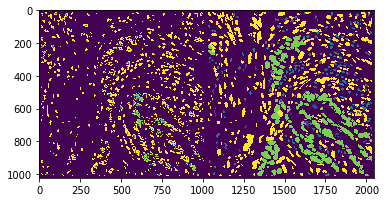

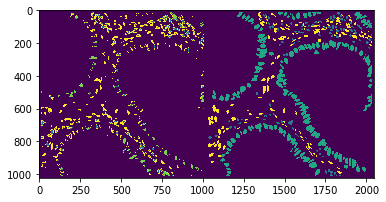

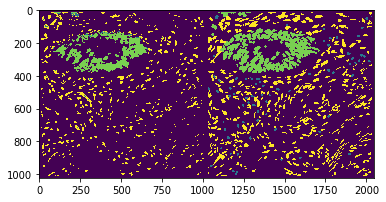

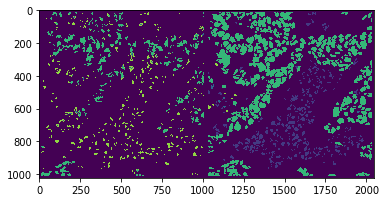

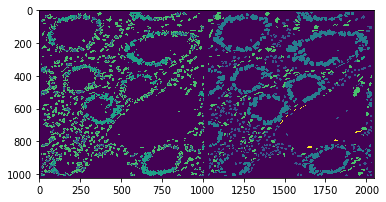

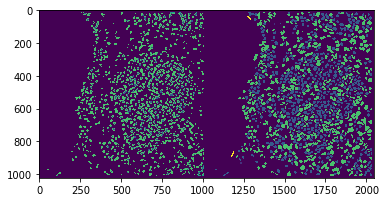

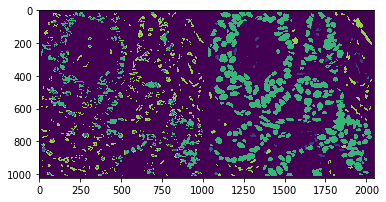

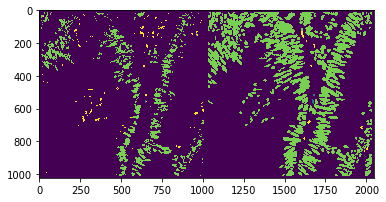

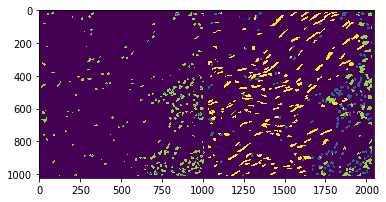

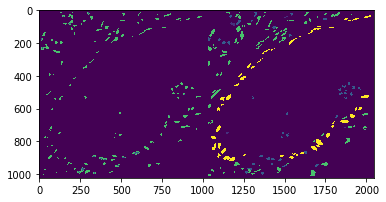

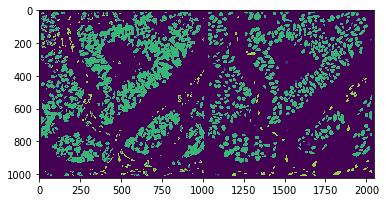

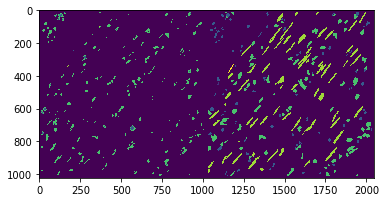

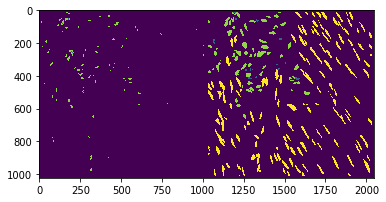

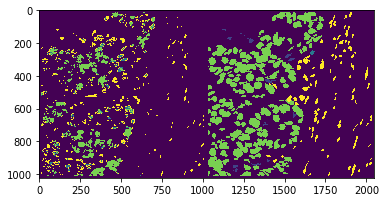


Test Loss: 0.558 | Test Acc: 84.02%
test metrics R, P, F1, F2
tensor([[9720, 8849, 9237, 9513],
        [   0,    0,    0,    0],
        [ 595, 1404,  711,  621],
        [   0,    0,    0,    0],
        [1443, 3125, 1687, 1501],
        [2474, 2443, 2054, 2148],
        [   0,    3,    0,    0],
        [   0,    0,    0,    0]])


In [ ]:
model.load_state_dict(torch.load(drivePath + 'unetplusplus.pt'))

test_loss, test_acc, test_stats = evaluate(model, test_generator, criterion, demo = True)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print('test metrics R, P, F1, F2')
print((test_stats * 1e4).long())